Sascha Spors,
Professorship Signal Theory and Digital Signal Processing,
Institute of Communications Engineering (INT),
Faculty of Computer Science and Electrical Engineering (IEF),
University of Rostock,
Germany

# Tutorial Digital Signal Processing

**DFT Fundamentals**,
Winter Semester 2021/22 (Course #24505)

- lecture: https://github.com/spatialaudio/digital-signal-processing-lecture
- tutorial: https://github.com/spatialaudio/digital-signal-processing-exercises

Feel free to contact lecturer frank.schultz@uni-rostock.de

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.fft import fft, ifft
#from scipy.fft import fft, ifft

# Discrete Fourier Transform (DFT)

## Input Signal

Let us first define a **complex-valued signal** $x[k]$ of a certain block length $N$ ranging from $0\leq k\leq N-1$.

The variable `tmpmu` defines the frequency of the signal. We will see later how this is connected to the DFT.
For now on, leave it with `tmpmu=1`. This results in exactly one period of cosine and sine building the complex signal. If `tmpmu=2` we get exactly two periods of cos/sin. We'll get get an idea of `tmpmu`...

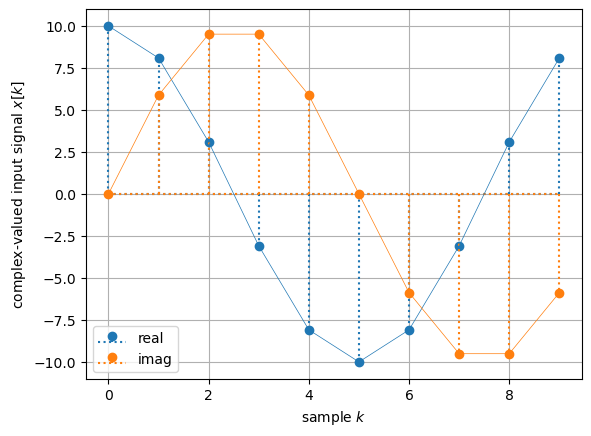

In [3]:
N = 10  # signal block length
k = np.arange(N)  # all required sample/time indices
A = 10  # signal amplitude

tmpmu = 2-1/2  # DFT eigenfrequency worst case
tmpmu = 1  # DFT eigenfrequency best case

x = A * np.exp(tmpmu * +1j*2*np.pi/N * k)

# plot
plt.stem(k, np.real(x), markerfmt='C0o',
         basefmt='C0:', linefmt='C0:', label='real')
plt.stem(k, np.imag(x), markerfmt='C1o',
         basefmt='C1:', linefmt='C1:', label='imag')
# note that connecting the samples by lines is actually wrong, we
# use it anyway for more visual convenience:
plt.plot(k, np.real(x), 'C0-', lw=0.5)
plt.plot(k, np.imag(x), 'C1-', lw=0.5)
plt.xlabel(r'sample $k$')
plt.ylabel(r'complex-valued input signal $x[k]$')
plt.legend()
plt.grid(True)

We will now perform an DFT of $x[k]$ since we are interested in the frequency spectrum of it.

## DFT Definition

The discrete Fourier transform pair for a discrete-time signal $x[k]$ with sample index $k$ and the corresponding DFT spectrum $X[\mu]$ with frequency index $\mu$ is given as 
\begin{align}
\text{DFT}: X[\mu]=&\sum_{k=0}^{N-1}x[k]\cdot\mathrm{e}^{-\mathrm{j}\frac{2\pi}{N}k\mu}\\
\text{IDFT}: x[k]=\frac{1}{N}&\sum_{\mu=0}^{N-1}X[\mu]\cdot\mathrm{e}^{+\mathrm{j}\frac{2\pi}{N}k\mu}
\end{align}

Note the sign reversal in the exp()-function and the $1/N$ normalization in the IDFT. This convention is used by the majority of DSP text books and also in Python's `numpy.fft.fft()`, `numpy.fft.ifft()` and Matlab's `fft()`, `ifft()` routines.

## DFT and IDFT with For-Loops

We are now going to implement the DFT and IDFT with for-loop handling. While this might be helpful to validate  algorithms in its initial development phase, this should be avoided for practical used code in the field: for-loops are typically slow and very often more complicated to read than appropriate set up matrices and vectors. Especially for very large $N$ the computation time is very long.

Anyway, the for-loop concept is: the DFT can be implemented with an outer for loop iterating over $\mu$ and an inner for loop summing over all $k$ for a specific $\mu$.

We use variable with _ subscript here, in order to save nice variable names for the matrix based calculation.

In [4]:
# DFT with for-loop:
X_ = np.zeros((N, 1), dtype=complex)  # alloc RAM, init with zeros
for mu_ in range(N):  # do for all DFT frequency indices
    for k_ in range(N):  # do for all sample indices
        X_[mu_] += x[k_] * np.exp(-1j*2*np.pi/N*k_*mu_)

IDFT with outer and inner looping reads as follows.

In [5]:
# IDFT with for-loop:
x_ = np.zeros((N, 1), dtype=complex)  # alloc RAM, init with zeros
for k_ in range(N):
    for mu_ in range(N):
        x_[k_] += X_[mu_] * np.exp(+1j*2*np.pi/N*k_*mu_)
x_ *= 1/N  # normalization in the IDFT stage

Besides exchanged variables, main differences are sign reversal in exp() and the $1/N$ normalization. This is expected due to the DFT/IDFT equation pair given above.

## DFT and IDFT with Matrix Multiplication

Now we do a little better: We should think of the DFT/IDFT in terms of a matrix operation setting up a set of linear equations.

For that we define a column vector containing the samples of the discrete-time signal $x[k]$
\begin{equation}
\mathbf{x}_k = (x[k=0], x[k=1], x[k=2], \dots , x[k=N-1])^\mathrm{T}
\end{equation}

and a column vector containing the DFT coefficients $X[\mu]$

\begin{equation}
\mathbf{x}_\mu = (X[\mu=0], X[\mu=1], X[\mu=2], \dots, X[\mu=N-1])^\mathrm{T}
\end{equation}

Then, the matrix operations

\begin{align}
\text{DFT:   } & \mathbf{x}_\mu = \mathbf{W}^* \mathbf{x}_k\\
\text{IDFT:   } & \mathbf{x}_k = \frac{1}{N} \mathbf{W} \mathbf{x}_\mu
\end{align}

hold.

$()^\mathrm{T}$ is the transpose, $()^*$ is the conjugate complex.


The $N\times N$ Fourier matrix is defined as (element-wise operation $\odot$)
\begin{equation}
\mathbf{W} = \mathrm{e}^{+\mathrm{j}\frac{2\pi}{N} \odot \mathbf{K}}
\end{equation}
using the so called twiddle factor (note that the sign in the exp() is our convention)
\begin{equation}
W_N = \mathrm{e}^{+\mathrm{j}\frac{2\pi}{N}}
\end{equation}
and the outer product
\begin{equation}
\mathbf{K} = 
\begin{bmatrix}
0\\
1\\
2\\
\vdots\\
N-1
\end{bmatrix}
\cdot
\begin{bmatrix}
0 & 1 & 2 & \cdots & N-1
\end{bmatrix}
\end{equation}
containing all possible products $k\,\mu$ in a suitable arrangement.

For the simple case $N=4$ these matrices are
\begin{align}
\mathbf{K} = \begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 2 & 3\\
0 & 2 & 4 & 6\\
0 & 3 & 6 & 9
\end{bmatrix}
\rightarrow
\mathbf{W} = \begin{bmatrix}
1 & 1 & 1 & 1\\
1 & +\mathrm{j} & -1 & -\mathrm{j}\\
1 & -1 & 1 & -1\\
1 & -\mathrm{j} & -1 & +\mathrm{j}
\end{bmatrix}
\end{align}

In [6]:
# k = np.arange(N)  # all required sample/time indices, already defined above

# all required DFT frequency indices, actually same entries like in k
mu = np.arange(N)

# set up matrices
K = np.outer(k, mu)  # get all possible entries k*mu in meaningful arrangement
W = np.exp(+1j * 2*np.pi/N * K)  # analysis matrix for DFT

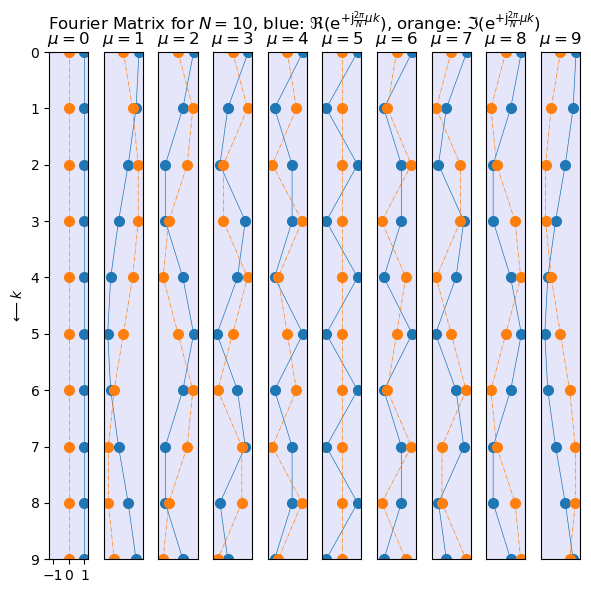

In [7]:
# visualize the content of the Fourier matrix
# we've already set up (use other N if desired):
# N = 8
# k = np.arange(N)
# mu = np.arange(N)
# W = np.exp(+1j*2*np.pi/N*np.outer(k, mu))  # set up Fourier matrix

fig, ax = plt.subplots(1, N)
fig.set_size_inches(6, 6)
fig.suptitle(
    r'Fourier Matrix for $N=$%d, blue: $\Re(\mathrm{e}^{+\mathrm{j} \frac{2\pi}{N} \mu k})$, orange: $\Im(\mathrm{e}^{+\mathrm{j} \frac{2\pi}{N} \mu k})$' % N)

for tmp in range(N):
    ax[tmp].set_facecolor('lavender')
    ax[tmp].plot(W[:, tmp].real, k, 'C0o-', ms=7, lw=0.5)
    ax[tmp].plot(W[:, tmp].imag, k, 'C1o-.', ms=7, lw=0.5)
    ax[tmp].set_ylim(N-1, 0)
    ax[tmp].set_xlim(-5/4, +5/4)
    if tmp == 0:
        ax[tmp].set_yticks(np.arange(0, N))
        ax[tmp].set_xticks(np.arange(-1, 1+1, 1))
        ax[tmp].set_ylabel(r'$\longleftarrow k$')
    else:
        ax[tmp].set_yticks([], minor=False)
        ax[tmp].set_xticks([], minor=False)
    ax[tmp].set_title(r'$\mu=$%d' % tmp)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

fig.savefig('fourier_matrix.png', dpi=300)

# TBD: row version for analysis

## Fourier Matrix Properties

The DFT and IDFT basically solve two sets of linear equations, that are linked as forward and inverse problem.

This is revealed with the important property of the Fourier matrix

\begin{equation}
\mathbf{W}^{-1}
= \frac{\mathbf{W}^\mathrm{H}}{N}
= \frac{\mathbf{W}^\mathrm{*}}{N},
\end{equation}

the latter holds since the matrix is symmetric.

Thus, we see that by our convention, the DFT is the inverse problem (signal analysis) and the IDFT is the forward problem (signal synthesis)

\begin{align}
\text{DFT:   } & \mathbf{x}_\mu = \mathbf{W}^* \mathbf{x}_k \rightarrow \mathbf{x}_\mu = N \mathbf{W}^{-1} \, \mathbf{x}_k\\
\text{IDFT:   } & \mathbf{x}_k = \frac{1}{N} \mathbf{W} \mathbf{x}_\mu.
\end{align}

The occurrence of the $N$, $1/N$ factor is due to the prevailing convention in signal processing literature.

If the matrix is normalised as $\frac{\mathbf{W}}{\sqrt{N}}$, a so called unitary matrix results, for which the 
important property
\begin{equation}
(\frac{\mathbf{W}}{\sqrt{N}})^\mathrm{H} \, (\frac{\mathbf{W}}{\sqrt{N}}) = \mathbf{I} =
(\frac{\mathbf{W}}{\sqrt{N}})^{-1} \, (\frac{\mathbf{W}}{\sqrt{N}})
\end{equation}
holds, i.e. the complex-conjugate, transpose is equal to the inverse
$(\frac{\mathbf{W}}{\sqrt{N}})^\mathrm{H} = (\frac{\mathbf{W}}{\sqrt{N}})^{-1}$
and due to the matrix symmetry also
$(\frac{\mathbf{W}}{\sqrt{N}})^* =
(\frac{\mathbf{W}}{\sqrt{N}})^{-1}$
is valid.

This tells that the matrix $\frac{\mathbf{W}}{\sqrt{N}}$ is **orthonormal**, i.e. the matrix spans a orthonormal vector basis (the best what we can get in linear algebra world to work with) of $N$ normalized DFT eigensignals.

So, DFT and IDFT is transforming vectors into other vectors using the vector basis of the Fourier matrix.


## Check DFT Eigensignals and -Frequencies

The columns of the Fourier matrix $\mathbf{W}$ contain the eigensignals of the DFT. These are
\begin{align}
w_\mu[k] = \cos(\frac{2\pi}{N} k \mu) + \mathrm{j} \sin(\frac{2\pi}{N} k \mu)
\end{align}
since we have intentionally set up the matrix this way.

The plot below shows the eigensignal for $\mu=1$, which fits again one signal period in the block length $N$.
For $\mu=2$ we obtain two periods in one block.

The eigensignals for $0\leq \mu \leq N-1$ therefore exhibit a certain digital frequency, the so called DFT eigenfrequencies.

What eigensignal corresponds to $\mu=0$?...

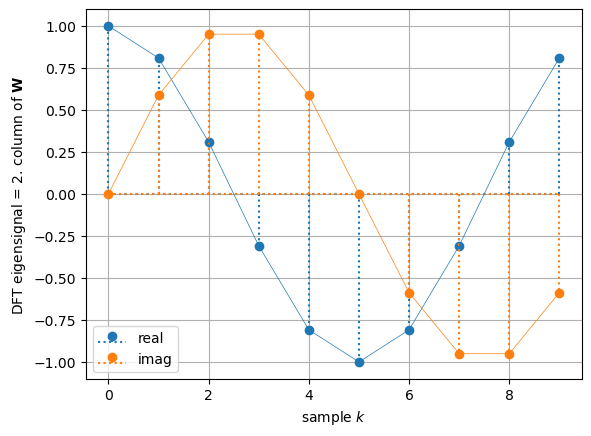

In [8]:
tmpmu = 1  # column index

plt.stem(k, np.real(W[:, tmpmu]), label='real',
         markerfmt='C0o', basefmt='C0:', linefmt='C0:')
plt.stem(k, np.imag(W[:, tmpmu]), label='imag',
         markerfmt='C1o', basefmt='C1:', linefmt='C1:')
# note that connecting the samples by lines is actually wrong, we
# use it anyway for more visual convenience
plt.plot(k, np.real(W[:, tmpmu]), 'C0-', lw=0.5)
plt.plot(k, np.imag(W[:, tmpmu]), 'C1-', lw=0.5)
plt.xlabel(r'sample $k$')
plt.ylabel(r'DFT eigensignal = '+str(tmpmu+1)+'. column of $\mathbf{W}$')
plt.legend()
plt.grid(True)

The nice thing about the chosen eigenfrequencies, is that the eigensignals are **orthogonal**.

This choice of the vector basis is on purpose and one of the most important ones in linear algebra and signal processing.

We might for example check orthogonality with the **complex** inner product of some matrix columns.

In [9]:
np.dot(np.conj(W[:, 0]), W[:, 0])  # same eigensignal, same eigenfrequency
# np.vdot(W[:,0],W[:,0])  # this is the suitable numpy function

(10+0j)

In [10]:
np.dot(np.conj(W[:, 0]), W[:, 1])  # different eigensignals
# np.vdot(W[:,0],W[:,1])  # this is the suitable numpy function
# result should be zero, with numerical precision close to zero:

(-2.220446049250313e-16+2.220446049250313e-16j)

## Initial Example: IDFT Signal Synthesis for N=8

Let us synthesize a discrete-time signal by using the IDFT in matrix notation for $N=8$.

The signal should contain a DC value, the first and second eigenfrequency with different amplitudes, such as

\begin{equation}
\mathbf{x}_\mu = [8, 2, 4, 0, 0, 0, 0, 0]^\text{T}
\end{equation}

using large `X_test` in code.

True
DC is 1 as expected:  (0.6+8.881784197001253e-17j)


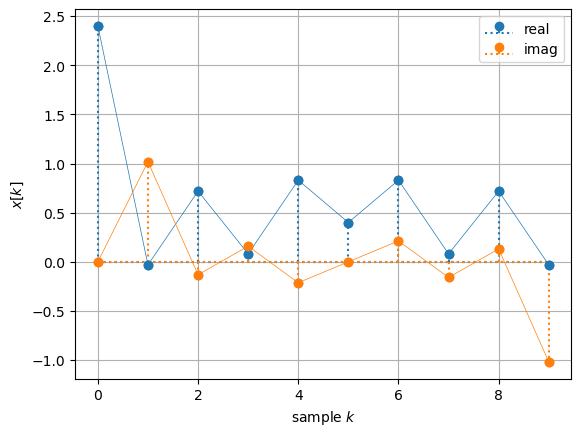

In [11]:
if N == 10:
    X_test = np.array([6, 2, 4, 3, 4, 5, 0, 0, 0, 0])
    # x_test = 1/N*W@X_test  # >= Python3.5
    x_test = 1/N * np.matmul(W, X_test)

    plt.stem(k, np.real(x_test), label='real',
             markerfmt='C0o', basefmt='C0:', linefmt='C0:')
    plt.stem(k, np.imag(x_test), label='imag',
             markerfmt='C1o', basefmt='C1:', linefmt='C1:')    
    # note that connecting the samples by lines is actually wrong, we
    # use it anyway for more visual convenience
    plt.plot(k, np.real(x_test), 'C0o-', lw=0.5)
    plt.plot(k, np.imag(x_test), 'C1o-', lw=0.5)
    plt.xlabel(r'sample $k$')
    plt.ylabel(r'$x[k]$')
    plt.legend()
    plt.grid(True)

    # check if results are identical with numpy ifft package
    print(np.allclose(ifft(X_test), x_test))
    print('DC is 1 as expected: ', np.mean(x_test))

This is a linear combination of the Fourier matrix columns, which are the DFT eigensignals, as 

In [12]:
if N == 10:
    x_test2 = X_test[0] * W[:, 0] + X_test[1] * W[:, 1] + X_test[2] * W[:, 2]

We don't need summing the other columns, since their DFT coefficients in `X_test` are zero.

Finally, normalizing yields the IDFT.

In [13]:
if N == 10:
    x_test2 *= 1/N
    print(np.allclose(x_test, x_test2))  # check with result before

False


## Initial Example: DFT Spectrum Analysis for N=8

Now, let us calculate the DFT of the signal `x_test`. As result, we'd expect the DFT vector

\begin{equation}
\mathbf{x}_\mu = [8, 2, 4, 0, 0, 0, 0, 0]^\text{T}
\end{equation}

that we started from.

In [14]:
if N == 10:
    # X_test2 = np.conj(W)@x_test  # >= Python3.5
    X_test2 = np.matmul(np.conj(W), x_test)  # DFT, i.e. analysis
    print(np.allclose(X_test, X_test2))  # check with result before

True


This looks good. It is advisable also to check against the `numpy.fft` implementation:

In [15]:
if N == 10:
    print(np.allclose(fft(x_test), X_test))

True


Besides different quantization errors in range $10^{-15...-16}$ (which is prominent even with 64Bit double precision calculation)
all results produce the same output.

The analysis stage for the discrete-time signal domain, i.e. the DFT
can be reinvented by some intuition:
How 'much' of the reference signal $\mathbf{w}_{\text{column i}}$
(any column in $\mathbf{W}$)
is contained in the discrete-time signal $\mathbf{x}_k$ that is to be analysed.

In signal processing / statistic terms we look for the amount of correlation
of the signals
$\mathbf{w}_{\text{column i}}$ and $\mathbf{x}_k$.

In linear algebra terms we are interested in the projection of $\mathbf{x}_k$ onto
$\mathbf{w}_{\text{column i}}$, because the resulting length of this vector
reveals the amount of correlation, which is precisely one DFT coefficient $X[\cdot]$.

The complex inner products $\mathbf{w}_{\text{column i}}^\text{H} \cdot \mathbf{x}_k$
reveals these searched quantities.

In [16]:
if N == 10:
    print(np.conj(W[:, 0])@x_test)
    print(np.conj(W[:, 1])@x_test)
    print(np.conj(W[:, 2])@x_test)

(5.999999999999999+8.326672684688674e-16j)
(1.9999999999999998+8.512903977548234e-16j)
(4+3.830362103929406e-16j)


Doing this for all columns of matrix $\mathbf{W}$, all DFT coefficients are obtained, such as

\begin{align}
X[\mu=0] =& \mathbf{w}_{\text{column 1}}^\text{H} \cdot \mathbf{x}_k\\
X[\mu=1] =& \mathbf{w}_{\text{column 2}}^\text{H} \cdot \mathbf{x}_k\\
X[\mu=2] =& \mathbf{w}_{\text{column 3}}^\text{H} \cdot \mathbf{x}_k\\
X[\mu=3] =& \mathbf{w}_{\text{column 4}}^\text{H} \cdot \mathbf{x}_k\\
&\vdots\\
X[\mu=N-1] =& \mathbf{w}_{\text{column N}}^\text{H} \cdot \mathbf{x}_k.
\end{align}

Naturally, all operations can be merged to one single
matrix multiplication using the conjugate transpose of $\mathbf{W}$.

\begin{equation}
\mathbf{x}_\mu = \mathbf{W}^\text{H} \cdot \mathbf{x}_k = \mathbf{W}^* \cdot \mathbf{x}_k
\end{equation}

That's what we have performed with the single liner `X_test2 = np.matmul(np.conj(W), x_test)`

## Example: Plot the DFT Magnitude Spectrum

We should now be familiar with the DFT and IDFT basic idea.

Now, let us **return to our initially created signal** `x` at the very beginning of this notebook. We want to explore and learn to interpret the DFT magnitude spectrum of it. So, we'd perform a DFT first.

In [17]:
X = fft(x)
# print(np.allclose(np.conj(W)@x, X))  # >=Python 3.5
print(np.allclose(np.matmul(np.conj(W), x), X))

True


Next, let us plot the magnitude of the spectrum over $\mu$.

- We should play around with the variable `tmpmu` when defining the input signal at the very beginning of the notebook. For example we can check what happens for `tmpmu = 1`, `tmpmu = 2` and run the whole notebook to visualize the actual magnitude spectra.

We should recognize the link of the 'energy' at $\mu$ in the magnitude spectrum with the chosen `tmpmu`.

- We can apply any real valued `tmpmu` for creating the input signal, for example
    - `tmpmu = N+1`, `tmpmu = N+2`
    - `tmpmu = 1.5`
    
We should explain what happens in these cases. Recall periodicity and eigenfrequencies/-signals as fundamental concepts.

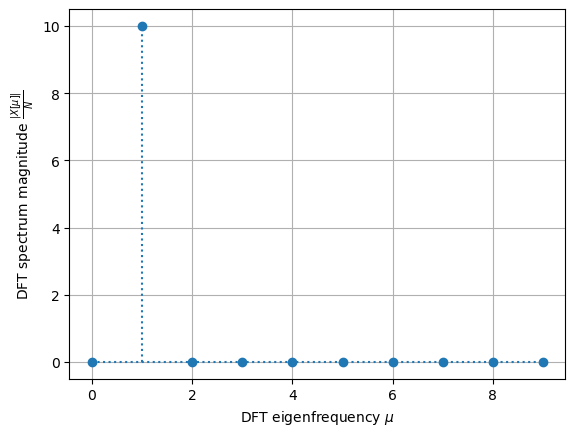

In [18]:
plt.stem(mu, np.abs(X)/N, markerfmt='C0o', basefmt='C0:', linefmt='C0:')
# plt.plot(mu, np.abs(X)/N, 'C0', lw=1)  # this is here a misleading plot and hence not used
plt.xlabel(r'DFT eigenfrequency $\mu$')
plt.ylabel(r'DFT spectrum magnitude $\frac{|X[\mu]|}{N}$')
plt.grid(True)

**Copyright**

The notebooks are provided as [Open Educational Resources](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebooks for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Frank Schultz, Digital Signal Processing - A Tutorial Featuring Computational Examples* with the URL https://github.com/spatialaudio/digital-signal-processing-exercises

In [19]:
print('W:', W)
print('K:', K)

W: [[ 1.        +0.00000000e+00j  1.        +0.00000000e+00j
   1.        +0.00000000e+00j  1.        +0.00000000e+00j
   1.        +0.00000000e+00j  1.        +0.00000000e+00j
   1.        +0.00000000e+00j  1.        +0.00000000e+00j
   1.        +0.00000000e+00j  1.        +0.00000000e+00j]
 [ 1.        +0.00000000e+00j  0.80901699+5.87785252e-01j
   0.30901699+9.51056516e-01j -0.30901699+9.51056516e-01j
  -0.80901699+5.87785252e-01j -1.        +1.22464680e-16j
  -0.80901699-5.87785252e-01j -0.30901699-9.51056516e-01j
   0.30901699-9.51056516e-01j  0.80901699-5.87785252e-01j]
 [ 1.        +0.00000000e+00j  0.30901699+9.51056516e-01j
  -0.80901699+5.87785252e-01j -0.80901699-5.87785252e-01j
   0.30901699-9.51056516e-01j  1.        -2.44929360e-16j
   0.30901699+9.51056516e-01j -0.80901699+5.87785252e-01j
  -0.80901699-5.87785252e-01j  0.30901699-9.51056516e-01j]
 [ 1.        +0.00000000e+00j -0.30901699+9.51056516e-01j
  -0.80901699-5.87785252e-01j  0.80901699-5.87785252e-01j
   0.309